In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression
import tensorflow as tf

2026-02-09 04:00:04.745563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 04:00:04.760389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770609604.778354    3601 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770609604.783738    3601 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770609604.797236    3601 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Try importing Sionna (Simulated Environment)
try:
    import sionna
    from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, PathSolver
    from sionna.phy.channel import subcarrier_frequencies
except ImportError:
    print("Sionna not installed. Please install via 'pip install sionna'")

In [3]:
# --- 1. CONFIGURATION ---
FILE_PATH = "/home/native/project/capture_50m_chunk.dat" # Update if needed
FS = 50e6               # Sample Rate
ZC_SEQ_LEN = 256        # Num Subcarriers (based on ZC Len)
M_KEEP = 2048           # Chunk size
SUBCARRIER_SPACING = FS / ZC_SEQ_LEN # ~195.3 kHz

# Zadoff-Chu Reference (From your provided notebook)
ZC_REF = np.array([
    1.0+0.0j, 1.0000+0.0000j, 0.9997-0.0246j, 0.9973-0.0739j, 0.9891-0.1473j,
    0.9698-0.2439j, 0.9325-0.3612j, 0.8691-0.4947j, 0.7713-0.6365j, 0.6317-0.7752j,
    0.4457-0.8952j, 0.2139-0.9768j, -0.0554-0.9985j, -0.3439-0.9390j, -0.6221-0.7829j,
    -0.8502-0.5264j, -0.9830-0.1837j, -0.9781+0.2079j, -0.8090+0.5878j, -0.4785+0.8781j,
    -0.0308+0.9995j, 0.4457+0.8952j, 0.8302+0.5575j, 0.9988+0.0493j, 0.8691-0.4947j,
    0.4457-0.8952j, -0.1534-0.9882j, -0.7136-0.7005j, -0.9939-0.1107j, -0.8370+0.5472j,
    -0.2737+0.9618j, 0.4457+0.8952j, 0.9411+0.3382j, 0.9032-0.4291j, 0.3090-0.9511j,
    -0.5000-0.8660j, -0.9830-0.1837j, -0.7634+0.6459j, 0.0431+0.9991j, 0.8302+0.5575j,
    0.9325-0.3612j, 0.2139-0.9768j, -0.7136-0.7005j, -0.9667+0.2558j, -0.2499+0.9683j,
    0.7390+0.6737j, 0.9325-0.3612j, 0.0677-0.9977j, -0.8868-0.4622j, -0.7634+0.6459j,
    0.3324+0.9432j, 1.0000+0.0000j, 0.3090-0.9511j, -0.8233-0.5677j, -0.7634+0.6459j,
    0.4457+0.8952j, 0.9698-0.2439j, -0.0554-0.9985j, -0.9939-0.1107j, -0.2499+0.9683j,
    0.9325+0.3612j, 0.4457-0.8952j, -0.8629-0.5053j, -0.5421+0.8403j, 0.8302+0.5575j,
    0.5524-0.8336j, -0.8502-0.5264j, -0.4785+0.8781j, 0.9135+0.4067j, 0.3090-0.9511j,
    -0.9830-0.1837j, -0.0308+0.9995j, 0.9891-0.1473j, -0.3439-0.9390j, -0.8370+0.5472j,
    0.7390+0.6737j, 0.4457-0.8952j, -0.9872-0.1595j, 0.1656+0.9862j, 0.8691-0.4947j,
    -0.7791-0.6269j, -0.2737+0.9618j, 0.9891-0.1473j, -0.5626-0.8267j, -0.4785+0.8781j,
    1.0000+0.0000j, -0.5000-0.8660j, -0.4785+0.8781j, 0.9973-0.0739j, -0.6221-0.7829j,
    -0.2737+0.9618j, 0.9325-0.3612j, -0.8629-0.5053j, 0.1656+0.9862j, 0.6317-0.7752j,
    -0.9981+0.0616j, 0.7390+0.6737j, -0.0554-0.9985j, -0.6412+0.7674j, 0.9891-0.1473j,
    -0.8502-0.5264j, 0.3324+0.9432j, 0.3090-0.9511j, -0.8090+0.5878j, 0.9997-0.0246j,
    -0.8502-0.5264j, 0.4457+0.8952j, 0.0677-0.9977j, -0.5421+0.8403j, 0.8691-0.4947j,
    -0.9981+0.0616j, 0.9325+0.3612j, -0.7136-0.7005j, 0.4011+0.9160j, -0.0554-0.9985j,
    -0.2737+0.9618j, 0.5524-0.8336j, -0.7634+0.6459j, 0.9032-0.4291j, -0.9781+0.2079j,
    1.0000+0.0000j, -0.9830-0.1837j, 0.9411+0.3382j, -0.8868-0.4622j, 0.8302+0.5575j,
    -0.7791-0.6269j, 0.7390+0.6737j, -0.7136-0.7005j, 0.7049+0.7093j, -0.7136-0.7005j,
    0.7390+0.6737j, -0.7791-0.6269j, 0.8302+0.5575j, -0.8868-0.4622j, 0.9411+0.3382j,
    -0.9830-0.1837j, 1.0000+0.0000j, -0.9781+0.2079j, 0.9032-0.4291j, -0.7634+0.6459j,
    0.5524-0.8336j, -0.2737+0.9618j, -0.0554-0.9985j, 0.4011+0.9160j, -0.7136-0.7005j,
    0.9325+0.3612j, -0.9981+0.0616j, 0.8691-0.4947j, -0.5421+0.8403j, 0.0677-0.9977j,
    0.4457+0.8952j, -0.8502-0.5264j, 0.9997-0.0246j, -0.8090+0.5878j, 0.3090-0.9511j,
    0.3324+0.9432j, -0.8502-0.5264j, 0.9891-0.1473j, -0.6412+0.7674j, -0.0554-0.9985j,
    0.7390+0.6737j, -0.9981+0.0616j, 0.6317-0.7752j, 0.1656+0.9862j, -0.8629-0.5053j,
    0.9325-0.3612j, -0.2737+0.9618j, -0.6221-0.7829j, 0.9973-0.0739j, -0.4785+0.8781j,
    -0.5000-0.8660j, 1.0000+0.0000j, -0.4785+0.8781j, -0.5626-0.8267j, 0.9891-0.1473j,
    -0.2737+0.9618j, -0.7791-0.6269j, 0.8691-0.4947j, 0.1656+0.9862j, -0.9872-0.1595j,
    0.4457-0.8952j, 0.7390+0.6737j, -0.8370+0.5472j, -0.3439-0.9390j, 0.9891-0.1473j,
    -0.0308+0.9995j, -0.9830-0.1837j, 0.3090-0.9511j, 0.9135+0.4067j, -0.4785+0.8781j,
    -0.8502-0.5264j, 0.5524-0.8336j, 0.8302+0.5575j, -0.5421+0.8403j, -0.8629-0.5053j,
    0.4457-0.8952j, 0.9325+0.3612j, -0.2499+0.9683j, -0.9939-0.1107j, -0.0554-0.9985j,
    0.9698-0.2439j, 0.4457+0.8952j, -0.7634+0.6459j, -0.8233-0.5677j, 0.3090-0.9511j,
    1.0000+0.0000j, 0.3324+0.9432j, -0.7634+0.6459j, -0.8868-0.4622j, 0.0677-0.9977j,
    0.9325-0.3612j, 0.7390+0.6737j, -0.2499+0.9683j, -0.9667+0.2558j, -0.7136-0.7005j,
    0.2139-0.9768j, 0.9325-0.3612j, 0.8302+0.5575j, 0.0431+0.9991j, -0.7634+0.6459j,
    -0.9830-0.1837j, -0.5000-0.8660j, 0.3090-0.9511j, 0.9032-0.4291j, 0.9411+0.3382j,
    0.4457+0.8952j, -0.2737+0.9618j, -0.8370+0.5472j, -0.9939-0.1107j, -0.7136-0.7005j,
    -0.1534-0.9882j, 0.4457-0.8952j, 0.8691-0.4947j, 0.9988+0.0493j, 0.8302+0.5575j,
    0.4457+0.8952j, -0.0308+0.9995j, -0.4785+0.8781j, -0.8090+0.5878j, -0.9781+0.2079j,
    -0.9830-0.1837j, -0.8502-0.5264j, -0.6221-0.7829j, -0.3439-0.9390j, -0.0554-0.9985j,
    0.2139-0.9768j, 0.4457-0.8952j, 0.6317-0.7752j, 0.7713-0.6365j, 0.8691-0.4947j,
    0.9325-0.3612j, 0.9698-0.2439j, 0.9891-0.1473j, 0.9973-0.0739j, 0.9997-0.0246j,
    1.0000+0.0000j
], dtype=np.complex64)
ZC_REF_FREQ = np.fft.fft(ZC_REF)

In [4]:
# --- 2. MEASURED DATA PROCESSING FUNCTIONS ---

def estimate_and_correct_cfo(cirs, cfrs):
    if len(cirs) < 2: return cirs, cfrs
    peak_indices = np.argmax(np.abs(cirs), axis=1)
    complex_peaks = np.array([cirs[i, idx] for i, idx in enumerate(peak_indices)])
    phase_diffs = complex_peaks[1:] * np.conj(complex_peaks[:-1])
    avg_phase_diff = np.angle(np.mean(phase_diffs))
    
    num_symbols = len(cfrs)
    correction_vector = np.exp(-1j * avg_phase_diff * np.arange(num_symbols))
    corrected_cfrs = cfrs * correction_vector[:, np.newaxis]
    corrected_cirs = np.fft.ifft(corrected_cfrs, axis=1)
    return corrected_cirs, corrected_cfrs

def estimate_and_correct_sro(cirs, cfrs):
    if len(cirs) < 2: return cirs, cfrs
    first_sym_phase = np.unwrap(np.angle(cfrs[0]))
    last_sym_phase = np.unwrap(np.angle(cfrs[-1]))
    X = np.arange(len(first_sym_phase)).reshape(-1, 1)
    slope_first = LinearRegression().fit(X, first_sym_phase).coef_[0]
    slope_last = LinearRegression().fit(X, last_sym_phase).coef_[0]
    slope_drift = slope_last - slope_first
    
    num_symbols = len(cfrs)
    subcarriers = np.arange(cfrs.shape[1])
    corrected_cfrs = np.zeros_like(cfrs)
    for i in range(num_symbols):
        current_drift = slope_drift * (i / (num_symbols - 1))
        correction_ramp = np.exp(-1j * current_drift * subcarriers)
        corrected_cfrs[i] = cfrs[i] * correction_ramp
    return np.fft.ifft(corrected_cfrs, axis=1), corrected_cfrs

def process_measured_data(file_path):
    print("--- Processing Measured Data ---")
    try:
        rx_raw = np.fromfile(file_path, dtype=np.complex64)
    except FileNotFoundError:
        print("WARN: File not found. Generating dummy data for logic check.")
        # Dummy: 500 repeated symbols + noise
        rx_raw = np.tile(ZC_REF, 500) + 0.1*(np.random.randn(500*256)+1j*np.random.randn(500*256))

    num_full_chunks = len(rx_raw) // M_KEEP
    rx_chunks = rx_raw[:num_full_chunks * M_KEEP].reshape(num_full_chunks, M_KEEP)
    
    all_corrected_cfrs = []
    
    # Simple processing loop (simplified from notebook for speed)
    for chunk in rx_chunks:
        # Correlation
        chunk_fft = np.fft.fft(chunk)
        zc_padded_fft = np.fft.fft(ZC_REF, n=len(chunk))
        mag = np.abs(np.fft.ifft(chunk_fft * np.conj(zc_padded_fft)))
        
        # Peak Finding (Height > 4*Std)
        threshold = np.mean(mag) + 4 * np.std(mag)
        peaks, _ = signal.find_peaks(mag, height=threshold, distance=ZC_SEQ_LEN)
        
        chunk_cirs, chunk_cfrs = [], []
        for p in peaks:
            if p + ZC_SEQ_LEN <= len(chunk):
                r_seq = chunk[p : p + ZC_SEQ_LEN]
                r_freq = np.fft.fft(r_seq)
                h_freq = r_freq * np.conj(ZC_REF_FREQ) # Estimate Channel
                chunk_cfrs.append(h_freq)
                chunk_cirs.append(np.fft.ifft(h_freq))
                
        if chunk_cfrs:
            _, final_cfrs = estimate_and_correct_sro(*estimate_and_correct_cfo(np.array(chunk_cirs), np.array(chunk_cfrs)))
            all_corrected_cfrs.append(final_cfrs)

    if not all_corrected_cfrs:
        raise ValueError("No symbols extracted from data.")
        
    # Stack -> (Total_Symbols, Subcarriers)
    full_cfr = np.vstack(all_corrected_cfrs)
    
    # Reshape for Sionna comparison: (1, 1, 1, 1, Time, Subcarriers)
    # The user snippet for Sionna output is [..., Time, Subcarriers]
    # So we format measured data to match that.
    h_measured = full_cfr[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :, :]
    
    print(f"Measured Data Shape: {h_measured.shape}")
    return h_measured

In [5]:
# --- 3. SIONNA SIMULATION ---

def generate_simulated_channel(num_subcarriers=256, subcarrier_spacing=195312.5):
    print("\n--- Generating Simulated Channel ---")
    
    # 1. Load Scene (Using Munich as fallback if specific file missing, or just empty if purely path tracing)
    # Note: User's XML path is local. We recreate the setup programmatically.
    scene = load_scene('/home/native/project/weeks_hall_final/weeks_hall_final.xml', merge_shapes=False)
    scene.frequency = 3.5e9
    scene.synthetic_array = True
    
    # 2. Setup Tx/Rx (Coordinates from your Sionna_feed.ipynb)
    scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
    scene.rx_array = PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
    
    tx = Transmitter(name="tx", position=[-6, 6.2, 3])
    scene.add(tx)
    rx = Receiver(name="rx", position=[-1.4, 2.8, 1.1])
    scene.add(rx)
    
    # 3. Path Finding
    p_solver = PathSolver()
    #paths = p_solver(scene=scene, max_depth=5, los=True, refraction=True, synthetic_array=True)
    
    paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)
    
    # 4. Generate CFR
    # We use fftfreq to generate frequencies corresponding to standard FFT order (0..Fs) 
    # to match the measured data's FFT order.
    # Relative frequencies: [0, 1, ..., 127, -128, ..., -1] * spacing
    frequencies = np.fft.fftfreq(num_subcarriers) * (subcarrier_spacing * num_subcarriers)
    
    h_freq = paths.cfr(frequencies=frequencies,
                       normalize=True, 
                       normalize_delays=True,
                       num_time_steps=1, # Static scene
                       out_type="numpy")
    
    # Result Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
    # e.g., (1, 1, 1, 1, 1, 256)
    print(f"Simulated Data Shape: {h_freq.shape}")
    return h_freq

--- Processing Measured Data ---
Measured Data Shape: (1, 1, 1, 1, 3587, 256)

--- Generating Simulated Channel ---
Simulated Data Shape: (1, 1, 1, 1, 1, 256)

--- Results ---
Mean Magnitude Error: 0.2362
Mean Phase Error (rad): 1.5695


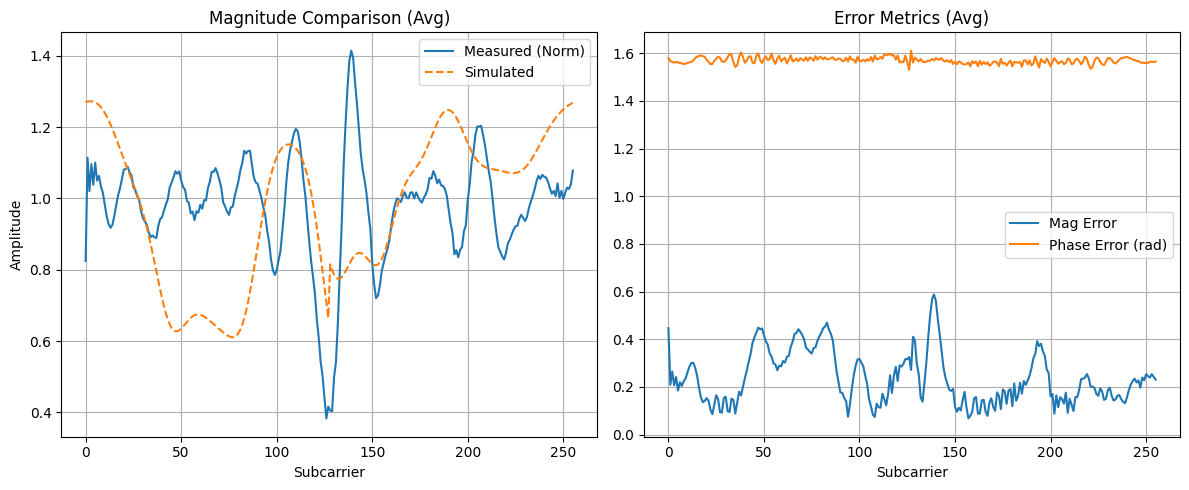

In [6]:
# --- 4. MAIN EXECUTION ---

# A. Get Data
h_meas = process_measured_data(FILE_PATH)
h_sim = generate_simulated_channel(num_subcarriers=ZC_SEQ_LEN, subcarrier_spacing=SUBCARRIER_SPACING)

# B. Align Dimensions
# h_meas: (1, 1, 1, 1, T_meas, 256)
# h_sim : (1, 1, 1, 1, 1, 256)
# Broadcast h_sim to match T_meas (assuming static channel simulation)
h_sim_broadcast = np.tile(h_sim, (1, 1, 1, 1, h_meas.shape[4], 1))

# C. Calculate Error
# Normalize power before comparison
scale_factor = np.mean(np.abs(h_sim_broadcast)) / np.mean(np.abs(h_meas))
h_meas_norm = h_meas * scale_factor

mag_error = np.abs(np.abs(h_meas_norm) - np.abs(h_sim_broadcast))
phase_error = np.abs(np.angle(h_meas_norm * np.conj(h_sim_broadcast))) # Difference in angle

print("\n--- Results ---")
print(f"Mean Magnitude Error: {np.mean(mag_error):.4f}")
print(f"Mean Phase Error (rad): {np.mean(phase_error):.4f}")

# D. Plotting
plt.figure(figsize=(12, 5))

# Plot Magnitude Comparison (Avg over time)
plt.subplot(1, 2, 1)
plt.plot(np.mean(np.abs(h_meas_norm[0,0,0,0,:,:]), axis=0), label='Measured (Norm)')
plt.plot(np.mean(np.abs(h_sim_broadcast[0,0,0,0,:,:]), axis=0), '--', label='Simulated')
plt.title("Magnitude Comparison (Avg)")
plt.xlabel("Subcarrier")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot Error
plt.subplot(1, 2, 2)
plt.plot(np.mean(mag_error[0,0,0,0,:,:], axis=0), label='Mag Error')
plt.plot(np.mean(phase_error[0,0,0,0,:,:], axis=0), label='Phase Error (rad)')
plt.title("Error Metrics (Avg)")
plt.xlabel("Subcarrier")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()